## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
import pydot as pyd
from itertools import chain

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [4]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [5]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [89]:
X_data = encoder_input_data#[:1000]
Y_data = decoder_input_data#[:1000]
print("X_data", X_data.shape)
print("Y_data", Y_data.shape)

X_data (4368, 3822, 4)
Y_data (4368, 3822, 4)


In [90]:
reverse_char_index = dict((i, char) for char, i in token_index.items())
decode_seq = lambda seq: [ ''.join([ reverse_char_index[i] for i in s ]) for s in np.argmax(seq, axis = 2)]

In [91]:
i = 5
print(decode_seq(X_data[i:i+1])[0])
print(decode_seq(Y_data[i:i+1])[0])

ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAA

In [92]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8538869424106563584
xla_global_id: -1
]


## Construct model

In [493]:
n_hidden = 8

In [494]:
input_train = Input(shape=(X_data.shape[1], X_data.shape[2]))
input_rand_rate = Input(shape=())
output_train = Input(shape=(Y_data.shape[1], Y_data.shape[2]))

print(input_train)
print(input_rand_rate)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_53'), name='input_53', description="created by layer 'input_53'")
KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name='input_54'), name='input_54', description="created by layer 'input_54'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_55'), name='input_55', description="created by layer 'input_55'")


In [495]:
splits = tf.split(input_train, num_or_size_splits=7 * 42, axis=1)
concat = tf.concat(splits, axis=0)
print(concat)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 4), dtype=tf.float32, name=None), name='tf.concat_50/concat:0', description="created by layer 'tf.concat_50'")


In [496]:
encoder_stack_h, encoder_last_h = GRU(
    n_hidden, dropout = 0.00, recurrent_dropout = 0.00,
    return_sequences = True, return_state = True)(concat)
print(encoder_stack_h)
print(encoder_last_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 8), dtype=tf.float32, name=None), name='gru_52/PartitionedCall:1', description="created by layer 'gru_52'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='gru_52/PartitionedCall:2', description="created by layer 'gru_52'")


In [497]:
encoder_last_h = BatchNormalization(momentum = 0.6)(encoder_last_h)
decoder_input = RepeatVector(concat.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 8), dtype=tf.float32, name=None), name='repeat_vector_26/Tile:0', description="created by layer 'repeat_vector_26'")


In [498]:
decoder_stack_h = GRU(n_hidden, dropout = 0.00, recurrent_dropout = 0.00,
 return_state = False, return_sequences = True)(
 decoder_input, initial_state = encoder_last_h)
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 8), dtype=tf.float32, name=None), name='gru_53/PartitionedCall:1', description="created by layer 'gru_53'")


In [499]:
attention = dot([decoder_stack_h, encoder_stack_h], axes = [2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 13), dtype=tf.float32, name=None), name='activation_28/Softmax:0', description="created by layer 'activation_28'")


In [500]:
class RandomDropout(keras.layers.Layer):
    
    def call(self, inputs, rate):
        return tf.nn.dropout(inputs, rate=rate[0])
    

In [502]:
context = dot([attention, encoder_stack_h], axes = [2,1])
context = BatchNormalization(momentum = 0.6)(context)
context = RandomDropout()(context, input_rand_rate)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 8), dtype=tf.float32, name=None), name='random_dropout_21/dropout/Mul:0', description="created by layer 'random_dropout_21'")


In [503]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 16), dtype=tf.float32, name=None), name='concatenate_26/concat:0', description="created by layer 'concatenate_26'")


In [504]:
out = TimeDistributed(Dense(concat.shape[2], activation = "softmax"))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 4), dtype=tf.float32, name=None), name='time_distributed_25/Reshape_1:0', description="created by layer 'time_distributed_25'")


In [505]:
back_splits = tf.split(out, num_or_size_splits=7*42, axis=0)
back_concat = tf.concat(back_splits, axis=1)
print(back_concat)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name=None), name='tf.concat_51/concat:0', description="created by layer 'tf.concat_51'")


In [506]:
model = Model(inputs = [input_train, input_rand_rate], outputs = back_concat)
opt = keras.optimizers.Adam(learning_rate = 0.01, clipnorm = 1)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_53 (InputLayer)          [(None, 3822, 4)]    0           []                               
                                                                                                  
 tf.split_50 (TFOpLambda)       [(None, 13, 4),      0           ['input_53[0][0]']               
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                            

                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
          

                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
          

                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
          

                                                                  'tf.split_50[0][32]',           
                                                                  'tf.split_50[0][33]',           
                                                                  'tf.split_50[0][34]',           
                                                                  'tf.split_50[0][35]',           
                                                                  'tf.split_50[0][36]',           
                                                                  'tf.split_50[0][37]',           
                                                                  'tf.split_50[0][38]',           
                                                                  'tf.split_50[0][39]',           
                                                                  'tf.split_50[0][40]',           
                                                                  'tf.split_50[0][41]',           
          

                                                                  'tf.split_50[0][115]',          
                                                                  'tf.split_50[0][116]',          
                                                                  'tf.split_50[0][117]',          
                                                                  'tf.split_50[0][118]',          
                                                                  'tf.split_50[0][119]',          
                                                                  'tf.split_50[0][120]',          
                                                                  'tf.split_50[0][121]',          
                                                                  'tf.split_50[0][122]',          
                                                                  'tf.split_50[0][123]',          
                                                                  'tf.split_50[0][124]',          
          

                                                                  'tf.split_50[0][198]',          
                                                                  'tf.split_50[0][199]',          
                                                                  'tf.split_50[0][200]',          
                                                                  'tf.split_50[0][201]',          
                                                                  'tf.split_50[0][202]',          
                                                                  'tf.split_50[0][203]',          
                                                                  'tf.split_50[0][204]',          
                                                                  'tf.split_50[0][205]',          
                                                                  'tf.split_50[0][206]',          
                                                                  'tf.split_50[0][207]',          
          

                                                                  'tf.split_50[0][281]',          
                                                                  'tf.split_50[0][282]',          
                                                                  'tf.split_50[0][283]',          
                                                                  'tf.split_50[0][284]',          
                                                                  'tf.split_50[0][285]',          
                                                                  'tf.split_50[0][286]',          
                                                                  'tf.split_50[0][287]',          
                                                                  'tf.split_50[0][288]',          
                                                                  'tf.split_50[0][289]',          
                                                                  'tf.split_50[0][290]',          
          

                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
          

                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
          

                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
          

                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4)]                                                   
          

                                                                  'tf.split_51[0][72]',           
                                                                  'tf.split_51[0][73]',           
                                                                  'tf.split_51[0][74]',           
                                                                  'tf.split_51[0][75]',           
                                                                  'tf.split_51[0][76]',           
                                                                  'tf.split_51[0][77]',           
                                                                  'tf.split_51[0][78]',           
                                                                  'tf.split_51[0][79]',           
                                                                  'tf.split_51[0][80]',           
                                                                  'tf.split_51[0][81]',           
          

                                                                  'tf.split_51[0][155]',          
                                                                  'tf.split_51[0][156]',          
                                                                  'tf.split_51[0][157]',          
                                                                  'tf.split_51[0][158]',          
                                                                  'tf.split_51[0][159]',          
                                                                  'tf.split_51[0][160]',          
                                                                  'tf.split_51[0][161]',          
                                                                  'tf.split_51[0][162]',          
                                                                  'tf.split_51[0][163]',          
                                                                  'tf.split_51[0][164]',          
          

                                                                  'tf.split_51[0][238]',          
                                                                  'tf.split_51[0][239]',          
                                                                  'tf.split_51[0][240]',          
                                                                  'tf.split_51[0][241]',          
                                                                  'tf.split_51[0][242]',          
                                                                  'tf.split_51[0][243]',          
                                                                  'tf.split_51[0][244]',          
                                                                  'tf.split_51[0][245]',          
                                                                  'tf.split_51[0][246]',          
                                                                  'tf.split_51[0][247]',          
          

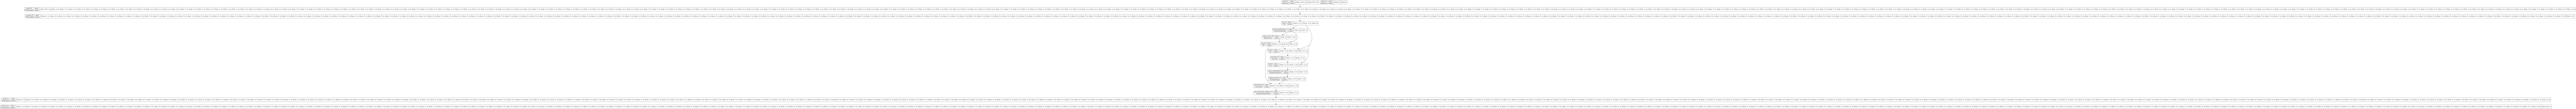

In [507]:
keras.utils.plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

## Train model

In [508]:
batch_size = 64      # Batch size for training.
patience = 10        # Patience for EarlyStop
epochs = 500         # Number of epochs to train for.
rand_rate = np.full((len(X_data)), 0.05)

In [509]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = patience, restore_best_weights = True)
history = model.fit([ X_data, rand_rate ], Y_data, 
                    validation_split = 0.2, 
                    epochs = epochs, verbose = 1, callbacks = [ es ], 
                    batch_size = batch_size)

# train_mae = history.history['accuracy']
# valid_mae = history.history['val_accuracy']

Epoch 1/500
55/55 [==============================] - 10s 140ms/step - loss: 1.2621 - accuracy: 0.4191 - val_loss: 1.2096 - val_accuracy: 0.4421
Epoch 2/500
55/55 [==============================] - 7s 130ms/step - loss: 1.1377 - accuracy: 0.4847 - val_loss: 1.0864 - val_accuracy: 0.5006
Epoch 3/500
55/55 [==============================] - 7s 129ms/step - loss: 1.0132 - accuracy: 0.5394 - val_loss: 0.9977 - val_accuracy: 0.5497
Epoch 4/500
55/55 [==============================] - 7s 129ms/step - loss: 0.9239 - accuracy: 0.5886 - val_loss: 0.8998 - val_accuracy: 0.5990
Epoch 5/500
55/55 [==============================] - 8s 150ms/step - loss: 0.8465 - accuracy: 0.6271 - val_loss: 0.8245 - val_accuracy: 0.6364
Epoch 6/500
55/55 [==============================] - 7s 131ms/step - loss: 0.7729 - accuracy: 0.6598 - val_loss: 0.7495 - val_accuracy: 0.6697
Epoch 7/500
55/55 [==============================] - 7s 131ms/step - loss: 0.7087 - accuracy: 0.6931 - val_loss: 0.7059 - val_accuracy: 0.696

Epoch 58/500
55/55 [==============================] - 7s 131ms/step - loss: 0.0194 - accuracy: 0.9952 - val_loss: 0.0193 - val_accuracy: 0.9951
Epoch 59/500
55/55 [==============================] - 7s 132ms/step - loss: 0.0189 - accuracy: 0.9953 - val_loss: 0.0186 - val_accuracy: 0.9953
Epoch 60/500
55/55 [==============================] - 7s 135ms/step - loss: 0.0185 - accuracy: 0.9954 - val_loss: 0.0182 - val_accuracy: 0.9955
Epoch 61/500
55/55 [==============================] - 8s 150ms/step - loss: 0.0181 - accuracy: 0.9955 - val_loss: 0.0179 - val_accuracy: 0.9956
Epoch 62/500
55/55 [==============================] - 7s 133ms/step - loss: 0.0177 - accuracy: 0.9957 - val_loss: 0.0175 - val_accuracy: 0.9956
Epoch 63/500
55/55 [==============================] - 7s 132ms/step - loss: 0.0172 - accuracy: 0.9958 - val_loss: 0.1869 - val_accuracy: 0.9627
Epoch 64/500
55/55 [==============================] - 7s 132ms/step - loss: 0.0801 - accuracy: 0.9785 - val_loss: 0.0314 - val_accuracy:

Epoch 115/500
55/55 [==============================] - 7s 130ms/step - loss: 0.0125 - accuracy: 0.9968 - val_loss: 0.0124 - val_accuracy: 0.9968


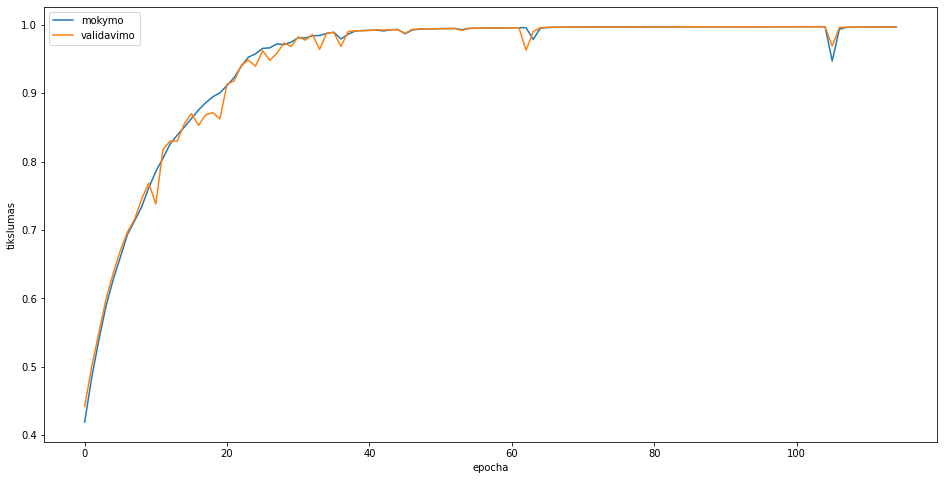

In [510]:
plt.plot(history.history['accuracy'], label = 'mokymo')
plt.plot(history.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.show()

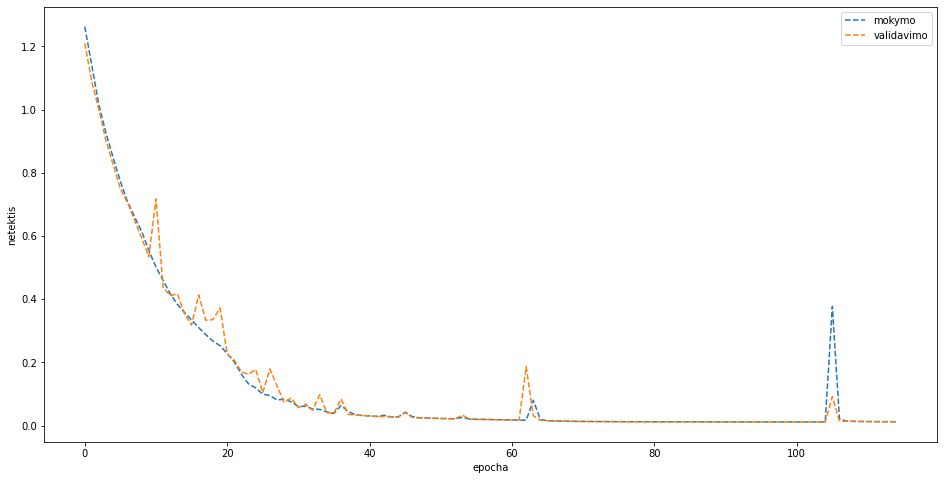

In [511]:
plt.plot(history.history['loss'], '--', label = 'mokymo')
plt.plot(history.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()

In [512]:
model.save("data/ncbi_02/model_gru_bi_256_8")

INFO:tensorflow:Assets written to: data/ncbi_02/model_gru_bi_256_8/assets


INFO:tensorflow:Assets written to: data/ncbi_02/model_gru_bi_256_8/assets
